### Tathagat Bhattacharyya

# **Amazon Product Recommendation System Project**

Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

## **Context:**

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [2]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict
from surprise.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:
df = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv', header = None, names = ['user_id', 'prod_id', 'rating', 'timestamp'])
df = df.drop(['timestamp'], axis = 1)
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
df.shape

(125871, 3)

**Write your observations here: This data has 125,871 rows and 3 columns.**

### **Data types**

In [ ]:
# Check Data types and provide observations
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 94 to 7824444
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  125871 non-null  object 
 1   prod_id  125871 non-null  object 
 2   rating   125871 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB


**Write your observations here: The user_id and prod_id columns contain object type values while the rating column contains float64 type values.**

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Write your observations here: There are no missing values in this data.**

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df.describe()

,rating
count,125871.000000
mean,4.261339
std,1.062144
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Write your observations here: The rating variable has a mean of 4.26 with a standard deviation of 1.06. The minimum is 1 and maximum is 5. The 25th percentile is 4 and 75th percentile is 5.**

### **Checking the rating distribution**

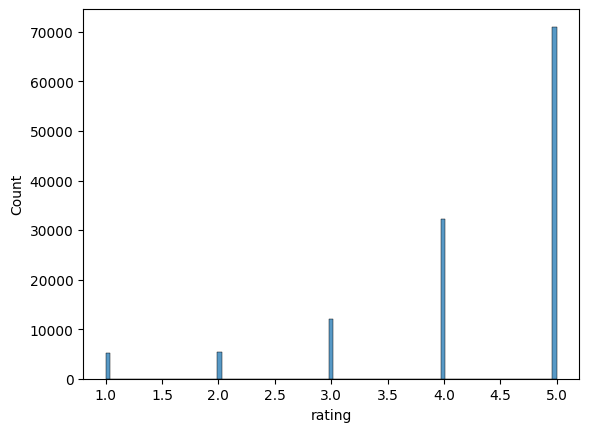

In [ ]:
# Create the histogram plot and provide observations
sns.histplot(data = df, x = 'rating')
plt.show()

**Write your observations here: Rating of 5 is the most common, followed by 4, then 3. The number of ratings of 1 and 2 are roughly the same, and are the least common.**

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
user = df['user_id'].unique()
len(user)

1540

In [ ]:
prod = df['prod_id'].unique()
len(prod)

48190

**Write your observations here: There are 1,540 unique users and 48,190 unique products.**

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
df['user_id'].value_counts().head(10)

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
Name: user_id, dtype: int64

**Write your observations here: The top 10 users are shown above. The user with the highest number of ratings is A5JLAU2ARJ0BO.**

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
avg = df.groupby('prod_id').mean()['rating']
# Calculate the count of ratings for each product
ct = df.groupby('prod_id').count()['rating']
# Create a dataframe with calculated average and count of ratings
rating_df = pd.DataFrame({'avg_rating':avg, 'rating_count':ct})
# Sort the dataframe by average of ratings in the descending order
final_rating = rating_df.sort_values('avg_rating', ascending = False)
# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
0594451647,5.0,1
B003RRY9RS,5.0,1
B003RR95Q8,5.0,1
B003RIPMZU,5.0,1
B003RFRNYQ,5.0,2


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_prod(final_rating, n, min_int):
# Finding products with minimum number of interactions
    rec = final_rating[final_rating['rating_count'] > min_int]
# Sorting values with respect to average rating
    rec = rec.sort_values(by = 'avg_rating', ascending = False)

    return rec.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
top_n_prod(final_rating, 5, 50)

Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='prod_id')

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
top_n_prod(final_rating, 5, 100)

Index(['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC'], dtype='object', name='prod_id')

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [5]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [6]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [7]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (1, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.25, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
so = {'name': 'cosine', 'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
knn_model = KNNBasic(sim_options = so, verbose = False, random_state = 1)

# Fit the model on the training data
knn_model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(knn_model)

RMSE: 1.1124
Precision:  0.849
Recall:  0.608
F_1 score:  0.709


**Write your observations here: The KNNBasic model has an RMSE of 1.1124, a precision of 0.849, a recall of 0.608, and an F1 score of 0.709.**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
knn_model.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

**Write your observations here: The actual rating is 5 and predicted rating is 3.33, so there is a significant difference.**

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
data2 = df[df.prod_id != '1400501466']
user = data2['user_id'].unique()
list(user)

['A3BY5KCNQZXV5U',
 'AT09WGFUM934H',
 'A32HSNCNPRUMTR',
 'A17HMM1M7T9PJ1',
 'A3CLWR1UUZT6TG',
 'A3TAS1AG6FMBQW',
 'A2Y4H3PXB07WQI',
 'A25RTRAPQAJBDJ',
 'A3LDPF5FMB782Z',
 'A18S2VGUH9SCV5',
 'A1K4G5YJDJQI6Q',
 'A1PPS91NLI7KEH',
 'A2ZR3YTMEEIIZ4',
 'A5JLAU2ARJ0BO',
 'A1P4XD7IORSEFN',
 'A341HCMGNZCBIT',
 'A3HPCRD9RX351S',
 'A20UU20K7M9ZPF',
 'A1DQHS7MOVYYYA',
 'ALUNVOQRXOZIA',
 'A19N3S7CBSU6O7',
 'A3G7BEJJCPD6DS',
 'A2JXS1JII6SAUD',
 'A2JOPUWVV0XQJ3',
 'A3PD8JD9L4WEII',
 'ABVYGB2TKBO8F',
 'A1NAA1R38JSNHV',
 'A1U5IJHJK84S54',
 'A30X750M8V1XXW',
 'A3QQGPI3CTV9SX',
 'A2JWF9IG8PJAOA',
 'A1ZU55TM45Y2R8',
 'A1VQHH85U7PX0',
 'A5A4374R8I7NB',
 'A10X9ME6R66JDX',
 'A14I1F2H7NOYDC',
 'A328GLDSDNFYII',
 'AAEVGE52KL0DJ',
 'A36K2N527TXXJN',
 'ADLVFFE4VBT8',
 'A3OZA8HNJM26DC',
 'A19HT7YC1UW3D6',
 'A16HXVNPU5TCGE',
 'A250AXLRBVYKB4',
 'A1C82BC5GNABOA',
 'A1VHCO8RQFIGQJ',
 'A2Z9S2RQD542CP',
 'A2QIC4G483SQQA',
 'A3L6L5O89JTX2T',
 'A1OGCPMSIVK7G4',
 'A18HE80910BTZI',
 'A3F9CBHV4OHFBS',
 'A2WXURU33RBGQS',
 '

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
knn_model.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 3.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=3.0, details={'actual_k': 1, 'was_impossible': False})

**Write your observations here: The predicted rating is 3.**

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
pg = {'k': [20, 30, 40], 'min_k': [3, 6, 9], 'sim_options': {'name': ['msd', 'cosine'], 'user_based': [True]}}
# Performing 3-fold cross-validation to tune the hyperparameters
three_fold = GridSearchCV(KNNBasic, pg, measures = ['rmse', 'mae'], cv = 3, n_jobs = -1)
# Fitting the data
three_fold.fit(data)
# Best RMSE score
print(three_fold.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(three_fold.best_params['rmse'])

1.0536892789546295
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim = {'name': 'msd', 'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
opt_model = KNNBasic(sim_options = sim, k = 20, min_k = 6, verbose = False)
# Training the algorithm on the trainset
opt_model.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(opt_model)

RMSE: 1.0591
Precision:  0.834
Recall:  0.601
F_1 score:  0.699


**Write your observations here: After tuning the hyperparameters, the RMSE went down from 1.1124 to 1.0591. The precision, recall, and F1 score values have slighlty decreased. Only the decrease in the RMSE suggests that this is a better model.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
opt_model.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.74   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.73758865248227, details={'actual_k': 6, 'was_impossible': False})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
opt_model.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.27   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.265341143819582, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here: For the first case, the predicted rating is 4.74 and for the second case, the predicted rating is 4.27. This optimized model seems to be more accurate than the baseline model because for the user with user_id = A3LDPF5FMB782Z, the predicted rating of 4.74 is closer to the actual rating of 5 than the predicted rating of 3.33 from the baseline model.**

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
opt_model.get_neighbors(0, k = 5)

[8, 19, 22, 25, 26]

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 1.2963
Precision:  0.679
Recall:  0.689
F_1 score:  0.684


**Write your observations here: This model has an RMSE of 1.2963, precision of 0.679, recall of 0.689, and F1 score of 0.684.**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.57   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.5742764310308495, details={'was_impossible': False})

**Write your observations here: The predicted rating is 4.57 which is close to the actual rating of 5.**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.53   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.526169876993571, details={'was_impossible': False})

**Write your observations here: The predicted rating is 4.53.**

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here: According to the rank based recommendation system, one of the top 5 recommended products based on popularity with both 50 and 100 minimum interactions is product id B003ES5ZUU. The optimized user-user similarity-based recommendation model has better performance than the baseline model, as indicated by its lower RMSE. The SVD model has a higher RMSE and lower precision than both the baseline and optimized user-user similarity-based models. Thus, the optimized user-user similarity-based recommendation model is the best.**

**Based on this analysis, I suggest that product id B003ES5ZUU should be included in a top 5 or top 10 list of recommended products for users. I also suggest using the optimized user-user similarity-based recommendation model for making better recommendations to users.**